# Jupyter Notebook to compute performance metrics from the segmentation predictions.

## Imports

In [14]:
import os
import json
from shutil import copy

# Scientific modules import
import imageio 
import numpy as np
from skimage import io
import matplotlib.pyplot as plt

# AxonDeepSeg import modules
from AxonDeepSeg.apply_model import axon_segmentation
from AxonDeepSeg.testing.segmentation_scoring import *

%matplotlib inline

## Use case: compute axon and myelin validation metrics on a sample image

In [32]:
path_img = '../AxonDeepSeg/data_test/image.png'

In [33]:
# Set paths
img = imageio.imread(path_img)
path_folder, file_name = os.path.split(path_img)
model_name = 'default_SEM_model_v1'
path_model = os.path.join('..','AxonDeepSeg','models',model_name)
path_configfile = os.path.join(path_model,'config_network.json')
with open(path_configfile, 'r') as fd:
    config_network = json.loads(fd.read())

# Groundtruth image
mask = imageio.imread(os.path.join(path_folder,'mask.png'))
gt_axon = mask[:,:,1] > 200
gt_myelin = np.logical_and(mask[:,:,1] >= 50, mask[:,:,1] <= 200)

# Prediction image (output of AxonDeepSeg)
pred = imageio.imread(os.path.join(path_folder,'image_seg-axonmyelin.png'))
pred_axon = pred > 200
pred_myelin = np.logical_and(pred >= 50, pred <= 200)

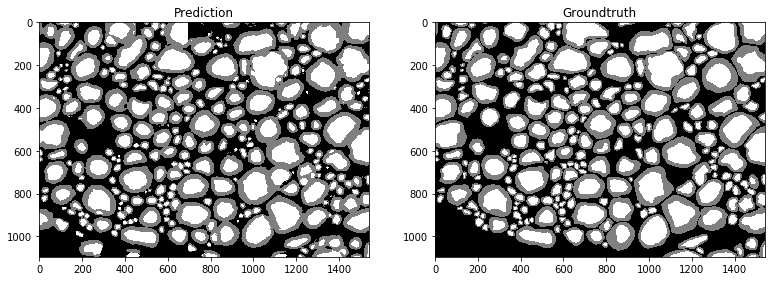

In [34]:
fig, axes = plt.subplots(1,2, figsize=(13,10))
ax1, ax2 = axes[0], axes[1]
ax1.set_title('Prediction')
ax1.imshow(pred,cmap='gray')
ax2.set_title('Groundtruth')
ax2.imshow(mask,cmap='gray')
plt.show();

## Compute validation metrics for axon segmentation

In [35]:
# Create object to manage segmentation metrics for axon mask
axon_metrics = Metrics_calculator(pred_axon, gt_axon)

# Compute and display results (pixelwise metrics):
print('Pixelwise Sensitivity:', axon_metrics.pw_sensitivity())
print('Pixelwise Accuracy:',axon_metrics.pw_accuracy())
print('Pixelwise Dice:',axon_metrics.pw_dice())
print('Pixelwise F1 score:',axon_metrics.pw_F1_score())
print('Pixelwise False negative rate:',axon_metrics.pw_FN_rate())
print('Pixelwise False positive rate:',axon_metrics.pw_FP_rate())
print('Pixelwise Jaccard index:',axon_metrics.pw_jaccard())
print('Pixelwise Precision:',axon_metrics.pw_precision())
print('Pixelwise Specificity:',axon_metrics.pw_specificity())

axon_metrics_array = np.array([axon_metrics.pw_sensitivity(),axon_metrics.pw_specificity(),axon_metrics.pw_precision(),
     axon_metrics.pw_accuracy(), axon_metrics.pw_F1_score(), axon_metrics.pw_dice(), axon_metrics.pw_jaccard()])

# Compute and display results (elementwise metrics):
dice_output = axon_metrics.ew_dice('all')

print('Elementwise Dice:',axon_metrics.ew_dice('short'))

Pixelwise Sensitivity: 0.8622353821550804
Pixelwise Accuracy: 0.9321472216827635
Pixelwise Dice: 0.8879289858658246
Pixelwise F1 score: 0.8879289858658246
Pixelwise False negative rate: 0.13776461784491956
Pixelwise False positive rate: 0.03618651401986539
Pixelwise Jaccard index: 0.7984462993643792
Pixelwise Precision: 0.9152008999219826
Pixelwise Specificity: 0.9638134859801346
Elementwise Dice: {'mean': 0.8661918603163106, 'std': 0.1253357841181281, 'min': 0.004779788323659952, 'max': 0.9745395707419217, 'percent_5': 0.7142351513437724, 'percent_10': 0.7838650508967523, 'percent_25': 0.8562064877247658, 'percent_50': 0.8941717791411042, 'percent_75': 0.9266285812640781, 'percent_90': 0.9486690620246968, 'percent_95': 0.958145034860763}


## Compute validation metrics for myelin segmentation

In [36]:
# Create object to manage segmentation metrics for myelin mask
myelin_metrics = Metrics_calculator(pred_myelin, gt_myelin)

# Compute and display results (pixelwise metrics):
print('Pixelwise Sensitivity:', myelin_metrics.pw_sensitivity())
print('Pixelwise Accuracy:',myelin_metrics.pw_accuracy())
print('Pixelwise Dice:',myelin_metrics.pw_dice())
print('Pixelwise F1 score:',myelin_metrics.pw_F1_score())
print('Pixelwise False negative rate:',myelin_metrics.pw_FN_rate())
print('Pixelwise False positive rate:',myelin_metrics.pw_FP_rate())
print('Pixelwise Jaccard index:',myelin_metrics.pw_jaccard())
print('Pixelwise Precision:',myelin_metrics.pw_precision())
print('Pixelwise Specificity:',myelin_metrics.pw_specificity())

myelin_metrics_array = np.array([myelin_metrics.pw_sensitivity(),myelin_metrics.pw_specificity(),myelin_metrics.pw_precision(),
                        myelin_metrics.pw_accuracy(), myelin_metrics.pw_F1_score(), myelin_metrics.pw_dice(), 
                        myelin_metrics.pw_jaccard()])

Pixelwise Sensitivity: 0.8338586478610963
Pixelwise Accuracy: 0.8611901220650161
Pixelwise Dice: 0.8049035215246819
Pixelwise F1 score: 0.804903521524682
Pixelwise False negative rate: 0.1661413521389037
Pixelwise False positive rate: 0.12451599057139717
Pixelwise Jaccard index: 0.6735050567227534
Pixelwise Precision: 0.7778918025983719
Pixelwise Specificity: 0.8754840094286028


## Visualization of pixelwise metrics for both axon and myelin

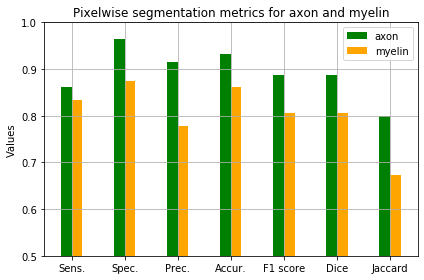

In [37]:
n_groups = 7
fig, ax = plt.subplots()
index = np.arange(n_groups)

ax.bar(index-0.1, axon_metrics_array, width=0.2, color='green',label='axon')
ax.bar(index+0.1, myelin_metrics_array, width=0.2, color='orange',label='myelin')

ax.set_ylabel('Values')
ax.set_title('Pixelwise segmentation metrics for axon and myelin')
ax.set_xticks(index)
ax.set_xticklabels(('Sens.', 'Spec.', 'Prec.', 'Accur.', 'F1 score','Dice','Jaccard'), minor=False, rotation=0)
ax.legend(loc='best')
ax.grid(True)
ax.set_ylim(0.5, 1)

plt.tight_layout()
plt.show()

## Visualization of elementwise Dice metric for axon objects

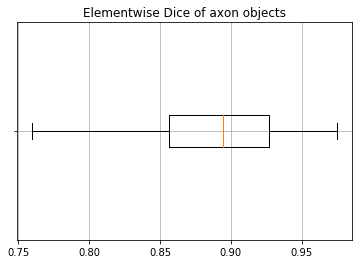

In [38]:
fig, ax = plt.subplots()
ax.boxplot(dice_output, 0, '',vert=False)
ax.set_title('Elementwise Dice of axon objects')
ax.grid(True)

# A way to remove the y labels
ax.set_yticklabels([]);
